In [11]:
import sys
import os

# Add the parent directory to the sys.path
sys.path.append(os.path.join(os.getcwd(), '..'))

In [12]:
# bimodality & gamma

In [13]:
import seaborn as sns
import numpy as np

from scipy.stats import kurtosis, skew, gaussian_kde
from scipy.signal import argrelextrema

from rcv_learning.rcv_distribution import *
from rcv_learning.rcv_dimensionality import *

In [14]:
import numpy as np
from scipy.stats import rankdata

def compute_ecdf(data):
    """Compute the empirical cumulative distribution function (ECDF) of data."""
    sorted_data = np.sort(data)
    n = len(data)
    return sorted_data, np.arange(1, n+1) / n

def dip_statistic(data):
    """Compute Hartigan's dip statistic for data."""
    data = np.sort(data)
    n = len(data)
    
    # Compute the empirical CDF
    x, ecdf = compute_ecdf(data)
    
    # Compute the greatest difference on the left and right side for each data point
    U = np.arange(1, n+1) / n
    D = U - np.arange(0, n) / n
    
    # Calculate the difference between the empirical distribution function and the 
    # unimodal distribution function that minimizes that maximum difference.
    low_dip = (ecdf - D).clip(min=0)
    up_dip = (U - ecdf).clip(min=0)
    both_dips = np.column_stack((low_dip, up_dip))
    
    # The dip statistic is the maximum difference over all data points
    dip = np.max(both_dips)
    
    return dip

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Tom Steyer': 0.0, 'Amy Klobuchar': 2.2929481554402114, 'Michael R. Bloomberg': 2.4564822253940473, 'Pete Buttigieg': 2.956130820440215, 'Bernie Sanders': 3.4350504601573033, 'Joseph R. Biden': 3.52399068249201, 'Elizabeth Warren': 3.916169474788022, 'Tulsi Gabbard': 7.0}


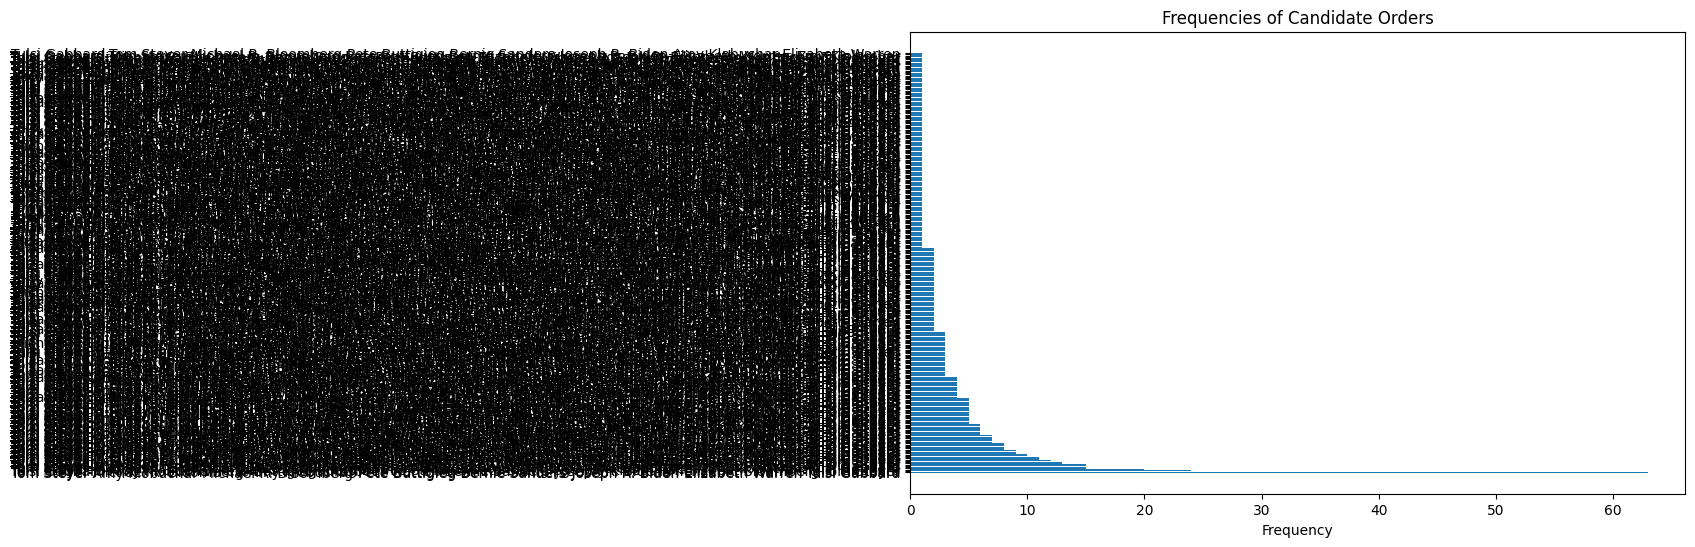

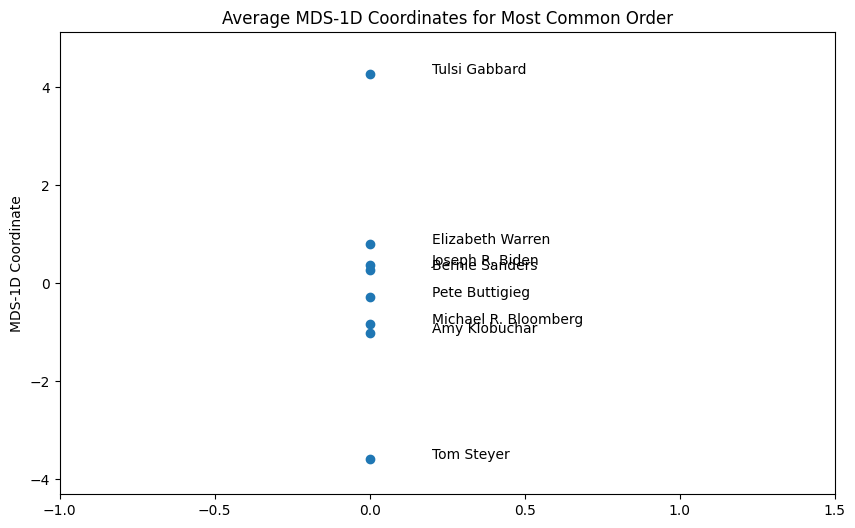

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {3.523990682492009: 2283, 3.457285515740979: 1831, 3.622035380566012: 141, 3.5096039812470377: 19, 3.4350504601573024: 1579, 3.5553302138149823: 435, 3.56542101540793: 15, 3.434926470733162: 30, 3.4556509290144124: 114, 3.495465258850346: 60, 3.635376771965514: 8, 3.468155064684537: 80, 3.2692581660103324: 5, 3.454016342287846: 13, 3.4125674257253453: 34, 4.326287845117977: 151, 3.437949351389531: 14, 3.46076136870047: 19, 3.4763753872956626: 52, 3.098095785953163: 16, 3.4885968234287668: 19, 3.0151979528281627: 3, 2.7233593396685376: 9, 2.5542374789651863: 2, 4.392993011869007: 16, 1.3154988353115011: 1, 3.916169474788021: 27, 3.5510528978095377: 53, 3.5147144209330947: 5, 2.29294815544021: 4, 2.6497311362401614: 3, 3.445147350105277: 15, 0.869880142831164: 3, 3.0356397115723923: 2, 3.3917998021683538: 38, 3.0752003687249005: 2, 7.0: 20, 3.0869782581613245: 9, 3.397420560776343: 32, 0.7720702880042578: 1, 2.701124284084861: 5, 3.433009184469575: 9, 3.51982486061915

In [15]:
# Test the function with a custom CSV file
csv = "../rcv_elections_database/single/Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv"

# Perform the RCV analysis
test = perform_rcv_analysis(csv, n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
print("Normalized distances:", get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(csv)
print("Consistency points:", points)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate KDE without plotting
density = gaussian_kde(data_points)
x_vals = np.linspace(min(data_points), max(data_points), 1000)
y_vals = density(x_vals)

# Identify local maxima in the KDE
maxima_indices = argrelextrema(y_vals, np.greater)

# Get the x-values of the maxima
modes = x_vals[maxima_indices]

# Check if there are at least two modes
if len(modes) >= 2:
    mode1, mode2 = modes[:2]

    # Calculate the amplitudes of the two modes
    amp1 = density(mode1)[0]
    amp2 = density(mode2)[0]

    # Calculate the amplitude ratio with higher amplitude as denominator
    if amp1 > amp2:
        amplitude_ratio = amp2 / amp1
    else:
        amplitude_ratio = amp1 / amp2

    # Calculate x-axis distance between the two modes
    mode_distance = abs(mode2 - mode1)

else:
    mode1, mode2 = None, None
    amplitude_ratio = None
    mode_distance = None

# Split the data into two groups based on proximity to the modes
data_group1 = [point for point in data_points if abs(point - mode1) < abs(point - mode2)]
data_group2 = [point for point in data_points if abs(point - mode1) > abs(point - mode2)]

# Display mean and variance for each group
mu1, sigma1_sq = np.mean(data_group1), np.var(data_group1)
mu2, sigma2_sq = np.mean(data_group2), np.var(data_group2)

# Display Ashman's D statistic (D > 2)
ashmans_D = abs(mu1 - mu2) / np.sqrt((sigma1_sq + sigma2_sq) / 2)
print("Ashman's D statistic:", ashmans_D)

# Display Sarle's bimodality coefficient b (b > 5/9)
n = len(data_points)
sarle = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))
print("Sarle's coefficient:", sarle)

# Display Hartigan's dip statistic ... (TODO - Permutation test)
hartigan_dip = dip_statistic(data_points)
print("Hartigan's Dip Statistic:", hartigan_dip)

# Display Amplitude Ratio
print("Amplitude Ratio:", amplitude_ratio)

# Display Mode Distance
print("Mode Distance:", mode_distance)


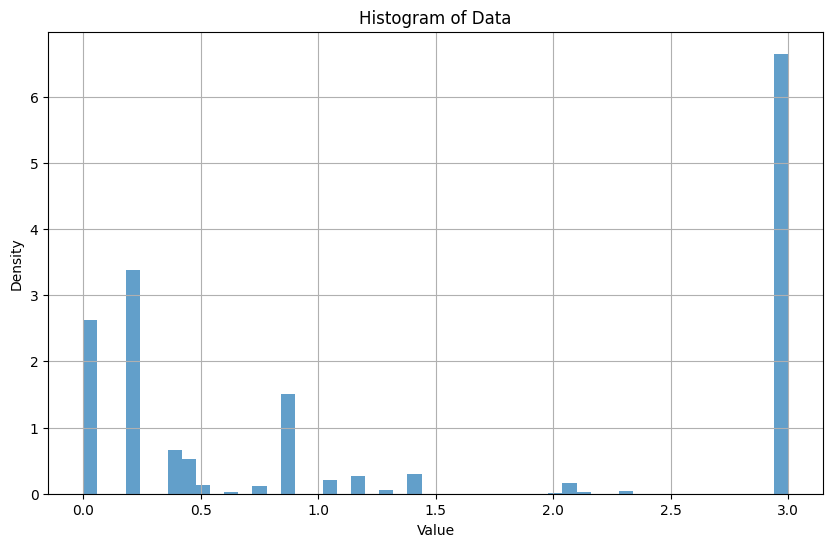

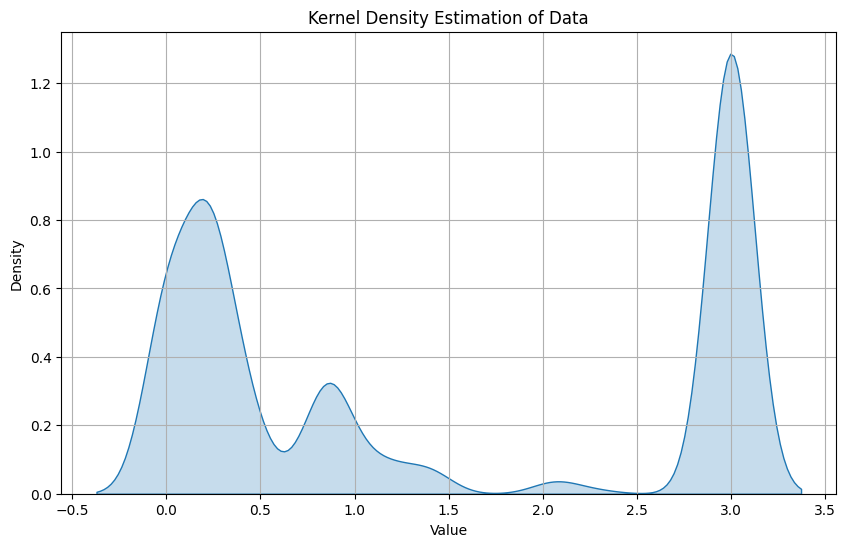

In [5]:
# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()